### Modelo Gradient Boosting para la predicción de victorias, empates y derrotas.
- **Preprocesamiento:** Conversión de variables categóricas, escalado de datos.
- **Optimización de Hiperparámetros:** Uso de Grid Search con validación cruzada.
- **Validación Secuencial:** Entrenamiento acumulativo para simular uso en tiempo real.
- **Evaluación del Modelo:** Accuracy, F1-score, recall, precision y matriz de confusión.
- **Registro en MLflow:** Monitorización del rendimiento del modelo.

In [ ]:
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")


In [2]:
import mlflow
import dagshub 

# Configurar MLflow con DagsHub
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

mlflow.set_tracking_uri(f"https://dagshub.com/anaigs/tfg_inso_github.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name=REPO_NAME, mlflow=True)

print(mlflow.get_tracking_uri()) 

Accessing as anaigs

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow


In [3]:
# Cargar datos
file_path = "../../datasets/datasets_equipos/ath_bilbao.csv"
df = pd.read_csv(file_path)


# Preprocesamiento de datos
df = df.drop(columns=["season", "date", "team"])
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]

In [4]:
# Separar datos en entrenamiento y validación secuencial
n_validacion = 38  # Última temporada completa para validación
X_train_init = X.iloc[: -n_validacion]
y_train_init = y.iloc[: -n_validacion]
X_val_seq = X.iloc[-n_validacion:]
y_val_seq = y.iloc[-n_validacion:]

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)
X_val_scaled = scaler.transform(X_val_seq)

In [ ]:
# Definir los hiperparámetros a optimizar
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Aplicar GridSearchCV con validación cruzada
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_init)

# Obtener los mejores parámetros
best_params = grid_search.best_params_

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

Accuracy del modelo Gradient Boosting Optimizado para Athletic Bilbao: 0.4737

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.33      1.00      0.50         8
  Empate (0)       0.00      0.00      0.00        11
Victoria (1)       0.71      0.53      0.61        19

    accuracy                           0.47        38
   macro avg       0.35      0.51      0.37        38
weighted avg       0.43      0.47      0.41        38



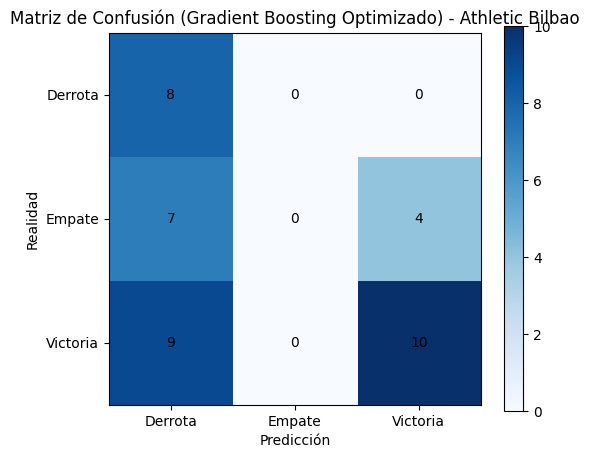

🏃 View run athletic_bilbao_gb_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/749cf03d79a64ca19509c544ae7f75e5
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
# Registrar experimento en MLflow
with mlflow.start_run(run_name="athletic_bilbao_gb_optimized"):
    mlflow.log_param("model_type", "Gradient Boosting")
    mlflow.log_param("approach", "Sequential Validation + Hyperparameter Tuning")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("test_size", n_validacion)
    mlflow.log_param("n_estimators", best_params["n_estimators"])
    mlflow.log_param("learning_rate", best_params["learning_rate"])
    mlflow.log_param("max_depth", best_params["max_depth"])
    mlflow.log_param("min_samples_split", best_params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])

    # Validacion secuencial
    for i in range(n_validacion):
        model_gb = GradientBoostingClassifier(**best_params, random_state=42)
        model_gb.fit(X_train_scaled, y_train_init)

        X_next = X_val_scaled[i:i+1]
        y_next = y_val_seq.iloc[i]

        y_pred_next = model_gb.predict(X_next)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_init = pd.concat([X_train_init, X_val_seq.iloc[i:i+1]])
        y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

        # Reescalar los datos con la nueva información incluida
        X_train_scaled = scaler.fit_transform(X_train_init)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo Gradient Boosting Optimizado para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Gradient Boosting Optimizado) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

### Conclusión: Gradient Boosting Optimizado para Athletic Bilbao

- **Precisión global:** 47.37%, similar a Random Forest, pero aún con margen de mejora.  
- **Predicción de derrotas:** 100% recall, pero baja precisión (33%), indicando un sesgo hacia predecir derrotas.  
- **Predicción de empates:** 0% recall y precisión, sigue siendo la categoría más difícil de clasificar.  
- **Predicción de victorias:** 53% recall, con una mejora en la precisión (71%), lo que indica que el modelo identifica mejor las victorias.  
- **Impacto de la optimización:** No se observaron mejoras significativas respecto a Random Forest, pero el modelo es más estable en victorias.  
- **Próximo paso:** Incluir PCA

### Modelo Gradient Boosting con PCA para la predicción de victorias, empates y derrotas.
- **Preprocesamiento:** Conversión de variables categóricas, escalado de datos y reducción de dimensionalidad con PCA.
- **Optimización de Hiperparámetros:** Nuevo Grid Search adaptado a la transformación PCA.
- **Validación Secuencial:** Entrenamiento acumulativo para simular uso en tiempo real.
- **Evaluación del Modelo:** Accuracy, F1-score, recall, precision y matriz de confusión.
- **Registro en MLflow:** Monitorización del rendimiento del modelo con PCA aplicado.

In [8]:
from sklearn.decomposition import PCA

# Separar datos en entrenamiento y validación secuencial
n_validacion = 38  # Última temporada completa para validación
X_train_init = X.iloc[: -n_validacion]
y_train_init = y.iloc[: -n_validacion]
X_val_seq = X.iloc[-n_validacion:]
y_val_seq = y.iloc[-n_validacion:]

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)
X_val_scaled = scaler.transform(X_val_seq)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [9]:
# Definir los hiperparámetros a optimizar
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Aplicar GridSearchCV con validación cruzada
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_pca, y_train_init)

# Obtener los mejores parámetros
best_params = grid_search.best_params_

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

Accuracy del modelo Gradient Boosting Optimizado con PCA para Athletic Bilbao: 0.4737

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.33      0.75      0.46         8
  Empate (0)       0.25      0.09      0.13        11
Victoria (1)       0.69      0.58      0.63        19

    accuracy                           0.47        38
   macro avg       0.42      0.47      0.41        38
weighted avg       0.49      0.47      0.45        38



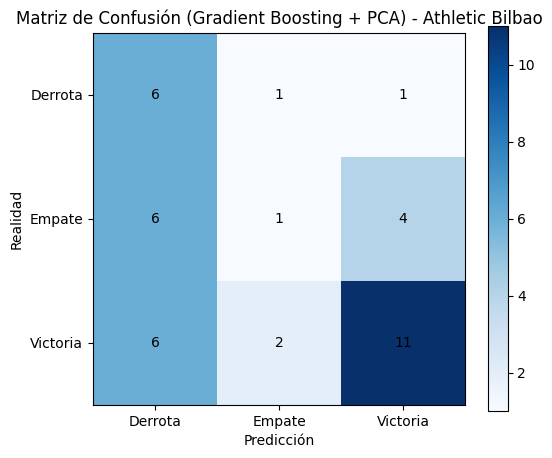

🏃 View run athletic_bilbao_gb_pca_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/373dd792f63a4e75a14f7948412a4541
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
# Registrar experimento en MLflow
with mlflow.start_run(run_name="athletic_bilbao_gb_pca_optimized"):
    mlflow.log_param("model_type", "Gradient Boosting + PCA")
    mlflow.log_param("approach", "Sequential Validation + Hyperparameter Tuning + PCA")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("test_size", n_validacion)
    mlflow.log_param("n_estimators", best_params["n_estimators"])
    mlflow.log_param("learning_rate", best_params["learning_rate"])
    mlflow.log_param("max_depth", best_params["max_depth"])
    mlflow.log_param("min_samples_split", best_params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])
    mlflow.log_param("pca_components", pca.n_components_)

    # Entrenamiento secuencial con PCA
    for i in range(n_validacion):
        model_gb = GradientBoostingClassifier(**best_params, random_state=42)
        model_gb.fit(X_train_pca, y_train_init)

        X_next = X_val_pca[i:i+1]
        y_next = y_val_seq.iloc[i]

        y_pred_next = model_gb.predict(X_next)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_init = pd.concat([X_train_init, X_val_seq.iloc[i:i+1]])
        y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

        # Reescalar y aplicar PCA con la nueva información incluida
        X_train_scaled = scaler.fit_transform(X_train_init)
        X_train_pca = pca.fit_transform(X_train_scaled)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo Gradient Boosting Optimizado con PCA para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Gradient Boosting + PCA) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

### Conclusión: Gradient Boosting + PCA para Athletic Bilbao

- **Precisión global:** 47.37%, sin mejora respecto al modelo sin PCA.  
- **Predicción de derrotas:** 75% recall, lo que indica que el modelo identifica derrotas con mayor frecuencia, pero la precisión sigue siendo baja (33%).  
- **Predicción de empates:** 9% recall, aunque mejora ligeramente, sigue siendo la categoría más difícil de clasificar.  
- **Predicción de victorias:** 58% recall con 69% de precisión, mejorando ligeramente la identificación de victorias en comparación con el modelo sin PCA.  
- **Impacto de PCA:**  
  - No mejora significativamente el rendimiento general del modelo.  
  - Se observa una leve mejora en la clasificación de empates y victorias, pero la precisión en derrotas sigue siendo baja.  
- **Próximo paso:**  
  - **Explorar técnicas de balanceo de clases**, como oversampling de empates o reponderación de clases.  

### Modelo Gradient Boosting con PCA y Balanceo de Clases
- **Preprocesamiento:** Conversión de variables categóricas, escalado de datos y reducción de dimensionalidad con PCA.
- **Balanceo de Clases:**  
  - Oversampling con **SMOTE** para aumentar la cantidad de empates.  
  - Undersampling de las clases mayoritarias (victorias y derrotas).  
- **Optimización de Hiperparámetros:** Nuevo **Grid Search** tras el balanceo de datos.  
- **Validación Secuencial:** Entrenamiento acumulativo para simular uso en tiempo real.  

In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Separar datos en entrenamiento y validación secuencial
n_validacion = 38  
X_train_init = X.iloc[: -n_validacion]
y_train_init = y.iloc[: -n_validacion]
X_val_seq = X.iloc[-n_validacion:]
y_val_seq = y.iloc[-n_validacion:]

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)
X_val_scaled = scaler.transform(X_val_seq)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Aplicar técnicas de balanceo de clases
smote = SMOTE(sampling_strategy="auto", random_state=42)
under = RandomUnderSampler(sampling_strategy="auto", random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train_init)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

In [12]:

# Definir los hiperparámetros a optimizar
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Aplicar GridSearchCV con validación cruzada
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores parámetros
best_params = grid_search.best_params_

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

Accuracy del modelo Gradient Boosting Optimizado con PCA y Balanceo para Athletic Bilbao: 0.3684

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.40      0.75      0.52         8
  Empate (0)       0.11      0.09      0.10        11
Victoria (1)       0.50      0.37      0.42        19

    accuracy                           0.37        38
   macro avg       0.34      0.40      0.35        38
weighted avg       0.37      0.37      0.35        38



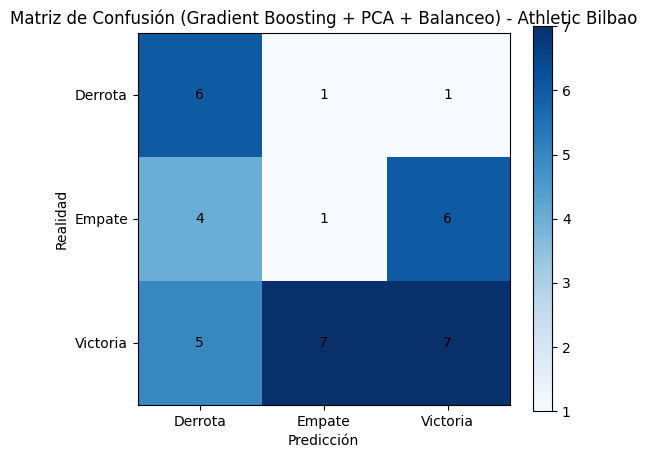

🏃 View run athletic_bilbao_gb_pca_balanced at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/db6fd5d247674e3dac8145e0a0769b3b
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
# Registrar experimento en MLflow
with mlflow.start_run(run_name="athletic_bilbao_gb_pca_balanced"):
    mlflow.log_param("model_type", "Gradient Boosting + PCA + Balanced")
    mlflow.log_param("approach", "Sequential Validation + Hyperparameter Tuning + PCA + Class Balancing")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("test_size", n_validacion)
    mlflow.log_param("n_estimators", best_params["n_estimators"])
    mlflow.log_param("learning_rate", best_params["learning_rate"])
    mlflow.log_param("max_depth", best_params["max_depth"])
    mlflow.log_param("min_samples_split", best_params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])
    mlflow.log_param("pca_components", pca.n_components_)

    # Entrenamiento secuencial con PCA y balanceo
    for i in range(n_validacion):
        model_gb = GradientBoostingClassifier(**best_params, random_state=42)
        model_gb.fit(X_resampled, y_resampled)

        X_next = X_val_pca[i:i+1]
        y_next = y_val_seq.iloc[i]

        y_pred_next = model_gb.predict(X_next)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_init = pd.concat([X_train_init, X_val_seq.iloc[i:i+1]])
        y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

        # Reescalar y aplicar PCA con la nueva información incluida
        X_train_scaled = scaler.fit_transform(X_train_init)
        X_train_pca = pca.fit_transform(X_train_scaled)

        # Aplicar balanceo nuevamente
        X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train_init)
        X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo Gradient Boosting Optimizado con PCA y Balanceo para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Gradient Boosting + PCA + Balanceo) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

### Conclusión: Gradient Boosting + PCA + Balanceo para Athletic Bilbao

- **Precisión global:** 36.84%, una caída respecto a los modelos anteriores.  
- **Predicción de derrotas:** 75% recall, pero con una precisión moderada (40%). Identifica bien las derrotas, pero a costa de errores en otras clases.  
- **Predicción de empates:** Sigue siendo deficiente, con **9% recall** y **11% precisión**, a pesar del balanceo de clases.  
- **Predicción de victorias:** 37% recall y 50% precisión, con un rendimiento inferior al modelo sin balanceo.  
- **Impacto del balanceo de clases:**  
  - **El modelo perdió precisión global** y se volvió menos efectivo en la clasificación general.  
  - **La predicción de empates mejoró solo mínimamente**, lo que indica que el problema puede no ser solo el desbalance de datos.  
  - **La clasificación de victorias y derrotas se volvió menos estable.**  

### Modelo XGBoost con PCA y Optuna para la predicción de victorias, empates y derrotas.
- **Preprocesamiento:** Conversión de variables categóricas, escalado de datos y reducción de dimensionalidad con PCA.  
- **Optimización de Hiperparámetros:** Uso de **Optuna** para encontrar los mejores parámetros de XGBoost de manera eficiente.  
- **Validación Secuencial:** Entrenamiento acumulativo para simular uso en tiempo real.  

In [1]:
# Importar librerías necesarias
import mlflow
import mlflow.sklearn
import dagshub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Configurar MLflow con DagsHub
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

mlflow.set_tracking_uri(f"https://dagshub.com/anaigs/tfg_inso_github.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name=REPO_NAME, mlflow=True)

Accessing as anaigs

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

In [23]:
# Cargar datos
file_path = "../../datasets/datasets_equipos/ath_bilbao.csv"
df = pd.read_csv(file_path)

# Preprocesamiento de datos
df = df.drop(columns=["season", "date", "team"])
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]

In [24]:
# Reasignar etiquetas para XGBoost (de -1, 0, 1 a 0, 1, 2)
y_mapped = y.replace({-1: 0, 0: 1, 1: 2})

# Número de partidos a usar en validación secuencial
n_validacion = 38  

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

# Dividir entrenamiento y validación
X_train_pca = X_pca[:-n_validacion]  # Datos de entrenamiento iniciales
y_train = y_mapped.iloc[:-n_validacion].copy()

X_val_pca = X_pca[-n_validacion:]  # Datos de validación
y_val = y_mapped.iloc[-n_validacion:].copy()

In [25]:
# Función de optimización con Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5)
    }
    
    # División interna para optimización
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
        X_train_pca, y_train, test_size=0.2, random_state=42, stratify=y_train)

    # Entrenar modelo
    model = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
    model.fit(X_train_opt, y_train_opt)
    
    # Evaluar modelo
    y_pred_opt = model.predict(X_val_opt)
    return accuracy_score(y_val_opt, y_pred_opt)

In [26]:
# Ejecutar Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Obtener los mejores parámetros
best_params = study.best_params
best_params["reg_lambda"] = best_params.pop("lambda")  # Ajuste de nombre

print("Mejores parámetros encontrados:", best_params)

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []


[I 2025-03-10 17:13:31,150] A new study created in memory with name: no-name-57f8a49d-3e42-4020-baad-f6593a845b62
[I 2025-03-10 17:13:31,439] Trial 0 finished with value: 0.4934210526315789 and parameters: {'n_estimators': 57, 'max_depth': 4, 'learning_rate': 0.1434267668489421, 'min_child_weight': 4, 'subsample': 0.8649384995834787, 'colsample_bytree': 0.982133632932982, 'gamma': 2.572091398306208, 'lambda': 3.902187813779511}. Best is trial 0 with value: 0.4934210526315789.
[I 2025-03-10 17:13:32,856] Trial 1 finished with value: 0.4934210526315789 and parameters: {'n_estimators': 60, 'max_depth': 11, 'learning_rate': 0.010825459524497457, 'min_child_weight': 1, 'subsample': 0.9642418328411451, 'colsample_bytree': 0.7158661209169835, 'gamma': 1.1186967785884272, 'lambda': 2.488293610052421}. Best is trial 0 with value: 0.4934210526315789.
[I 2025-03-10 17:13:33,514] Trial 2 finished with value: 0.5197368421052632 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate':

Mejores parámetros encontrados: {'n_estimators': 290, 'max_depth': 12, 'learning_rate': 0.167993851223377, 'min_child_weight': 3, 'subsample': 0.6608413825897904, 'colsample_bytree': 0.6893976034423736, 'gamma': 4.3162375454115764, 'reg_lambda': 0.8855578109563532}


Accuracy del modelo XGBoost Optimizado con PCA y Optuna para Athletic Bilbao (Secuencial): 0.4211

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.44      0.88      0.58         8
  Empate (0)       0.00      0.00      0.00        11
Victoria (1)       0.56      0.47      0.51        19

    accuracy                           0.42        38
   macro avg       0.33      0.45      0.37        38
weighted avg       0.37      0.42      0.38        38



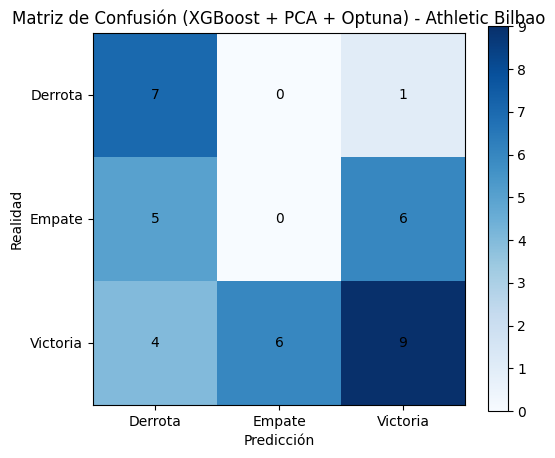

🏃 View run athletic_bilbao_xgboost_seq at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/71553430e308404eb781b4679fdf037b
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
with mlflow.start_run(run_name="athletic_bilbao_xgboost_seq"):
    mlflow.set_tag("team", "Athletic Bilbao")
    mlflow.log_param("model_type", "XGBoost + PCA + Optuna")
    mlflow.log_param("test_size", n_validacion)
    mlflow.log_param("approach", "Sequential Validation")

    # Registrar hiperparámetros
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    mlflow.log_param("pca_components", pca.n_components_)

    # Validación secuencial acumulativa
    for i in range(n_validacion):
        # Datos hasta el partido actual
        X_train_seq = X_pca[: -(n_validacion - i)]
        y_train_seq = y_mapped.iloc[: -(n_validacion - i)]

        X_test_seq = X_pca[-(n_validacion - i)].reshape(1, -1)
        y_test_seq = y_mapped.iloc[-(n_validacion - i)]

        # Entrenar modelo con los datos disponibles hasta ahora
        model_xgb = xgb.XGBClassifier(**best_params, random_state=42, enable_categorical=False, use_label_encoder=False, eval_metric="mlogloss")
        model_xgb.fit(X_train_seq, np.array(y_train_seq), verbose=False)

        # Predecir el siguiente partido
        y_pred_next = model_xgb.predict(X_test_seq)[0]

        # Guardar predicción y resultado real
        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_test_seq)

    # Convertir predicciones a etiquetas originales
    y_pred_series = pd.Series(y_pred_seq).replace({0: -1, 1: 0, 2: 1})
    y_real_series = pd.Series(y_real_seq).replace({0: -1, 1: 0, 2: 1})

    # Evaluación final
    accuracy = accuracy_score(y_real_series, y_pred_series)
    precision = precision_score(y_real_series, y_pred_series, average="weighted", zero_division=0)
    recall = recall_score(y_real_series, y_pred_series, average="weighted", zero_division=0)
    f1 = f1_score(y_real_series, y_pred_series, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_series, y_pred_series, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo XGBoost Optimizado con PCA y Optuna para Athletic Bilbao (Secuencial): {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_series, y_pred_series, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (XGBoost + PCA + Optuna) - Athletic Bilbao (Validación Secuencial)")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

### Conclusión: XGBoost + PCA + Optuna (Validación Secuencial) para Athletic Bilbao

- **Precisión global:** 42.11%, lo que indica un rendimiento moderado en la clasificación.  
- **Predicción de derrotas:** 88% de recall y 44% de precisión, lo que significa que el modelo **identifica bien las derrotas**, pero también asigna algunas incorrectamente.  
- **Predicción de empates:** Sigue siendo deficiente, con **0% de recall y precisión**, lo que indica que el modelo **no logra identificar correctamente los empates**.  
- **Predicción de victorias:** 47% de recall y 56% de precisión, mostrando un rendimiento aceptable, aunque con margen de mejora.  
- **Impacto del enfoque secuencial:**  
  - **El modelo logra captar patrones en derrotas y victorias, pero sigue fallando en empates.**  
  - **La ingeniería de características podría ser clave para mejorar la predicción de empates.**  


### Modelo XGBoost con PCA y Optuna para la predicción de victorias, empates y derrotas en múltiples equipos.

- **Preprocesamiento:** Carga de datos de los equipos ( `Valencia`, `Barcelona`, `Real Madrid`). Se aplicará conversión de variables categóricas, escalado de datos y reducción de dimensionalidad con PCA.  
- **Optimización de Hiperparámetros:** Uso de **Optuna** con 50 pruebas por equipo para encontrar los mejores parámetros de XGBoost.  
- **Validación Secuencial:** Entrenamiento acumulativo donde el modelo aprende de los partidos anteriores y predice el siguiente, simulando un uso en tiempo real.  
- **Registro de Resultados:** Se utilizará **MLflow** para almacenar los mejores hiperparámetros y métricas de desempeño (accuracy, precision, recall y f1-score) para cada equipo.  

In [29]:
# Lista de equipos y rutas de archivos
equipos = ["valencia", "barcelona", "real_madrid"]
file_path_template = "../../datasets/datasets_equipos/{}.csv"

[I 2025-03-10 17:39:06,958] A new study created in memory with name: no-name-0d8255fe-34d5-41b4-810d-c636e23390a1



🔹 Procesando equipo: VALENCIA


[I 2025-03-10 17:39:10,700] Trial 0 finished with value: 0.4144736842105263 and parameters: {'n_estimators': 171, 'max_depth': 11, 'learning_rate': 0.13474215444913046, 'min_child_weight': 3, 'subsample': 0.9455731770700855, 'colsample_bytree': 0.6724413772712154, 'gamma': 0.82447109323742, 'lambda': 3.417423914588768}. Best is trial 0 with value: 0.4144736842105263.
[I 2025-03-10 17:39:11,479] Trial 1 finished with value: 0.4407894736842105 and parameters: {'n_estimators': 145, 'max_depth': 10, 'learning_rate': 0.11724469031590495, 'min_child_weight': 3, 'subsample': 0.8516576952400499, 'colsample_bytree': 0.7655242895845005, 'gamma': 2.706386507135486, 'lambda': 0.5892754999987654}. Best is trial 1 with value: 0.4407894736842105.
[I 2025-03-10 17:39:12,367] Trial 2 finished with value: 0.4407894736842105 and parameters: {'n_estimators': 189, 'max_depth': 8, 'learning_rate': 0.29930913748999954, 'min_child_weight': 1, 'subsample': 0.790576752967721, 'colsample_bytree': 0.8642288251732

Mejores parámetros para VALENCIA: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.022029546167980252, 'min_child_weight': 5, 'subsample': 0.5064870067274088, 'colsample_bytree': 0.6235482669754524, 'gamma': 4.483424168010467, 'reg_lambda': 3.461760653044239}

📊 Resultados para VALENCIA: Accuracy=0.4737, Precision=0.3593, Recall=0.4737, F1-score=0.4006

Reporte de clasificación:
               precision    recall  f1-score   support

 Derrota (0)       0.53      0.53      0.53        15
  Empate (1)       0.00      0.00      0.00        10
Victoria (2)       0.43      0.77      0.56        13

    accuracy                           0.47        38
   macro avg       0.32      0.43      0.36        38
weighted avg       0.36      0.47      0.40        38



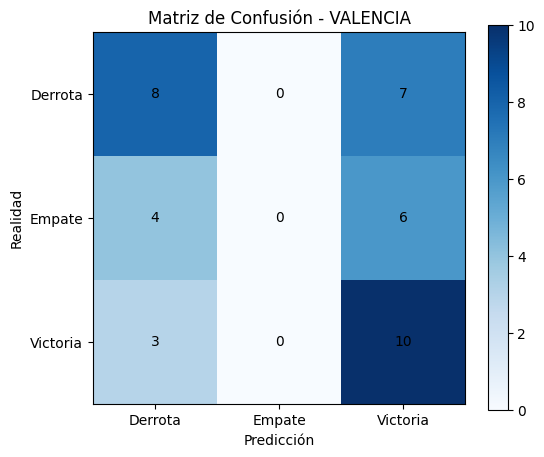

🏃 View run valencia_xgboost_seq at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/f36154598fa8439699e1f746000ffe7d
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


[I 2025-03-10 17:39:51,060] A new study created in memory with name: no-name-b2098f18-0e78-4dc1-afc9-9b9d7385af74
[I 2025-03-10 17:39:51,161] Trial 0 finished with value: 0.6907894736842105 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.20565621563436348, 'min_child_weight': 10, 'subsample': 0.9783892898987399, 'colsample_bytree': 0.5861335063775285, 'gamma': 3.7079846165776154, 'lambda': 4.608334369059519}. Best is trial 0 with value: 0.6907894736842105.



🔹 Procesando equipo: BARCELONA


[I 2025-03-10 17:39:51,369] Trial 1 finished with value: 0.6776315789473685 and parameters: {'n_estimators': 171, 'max_depth': 4, 'learning_rate': 0.17371081773555794, 'min_child_weight': 4, 'subsample': 0.9787216539133474, 'colsample_bytree': 0.9331043004243877, 'gamma': 2.3263414824180773, 'lambda': 1.3255186074022922}. Best is trial 0 with value: 0.6907894736842105.
[I 2025-03-10 17:39:51,879] Trial 2 finished with value: 0.6842105263157895 and parameters: {'n_estimators': 276, 'max_depth': 10, 'learning_rate': 0.15118290537325818, 'min_child_weight': 2, 'subsample': 0.5585028926262254, 'colsample_bytree': 0.5272822760377662, 'gamma': 3.288166032770083, 'lambda': 0.8105153001952109}. Best is trial 0 with value: 0.6907894736842105.
[I 2025-03-10 17:39:52,186] Trial 3 finished with value: 0.6578947368421053 and parameters: {'n_estimators': 130, 'max_depth': 12, 'learning_rate': 0.11734896503771952, 'min_child_weight': 8, 'subsample': 0.8402694536868127, 'colsample_bytree': 0.573921227

Mejores parámetros para BARCELONA: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.20565621563436348, 'min_child_weight': 10, 'subsample': 0.9783892898987399, 'colsample_bytree': 0.5861335063775285, 'gamma': 3.7079846165776154, 'reg_lambda': 4.608334369059519}

📊 Resultados para BARCELONA: Accuracy=0.6842, Precision=0.4681, Recall=0.6842, F1-score=0.5559

Reporte de clasificación:
               precision    recall  f1-score   support

 Derrota (0)       0.00      0.00      0.00         5
  Empate (1)       0.00      0.00      0.00         7
Victoria (2)       0.68      1.00      0.81        26

    accuracy                           0.68        38
   macro avg       0.23      0.33      0.27        38
weighted avg       0.47      0.68      0.56        38



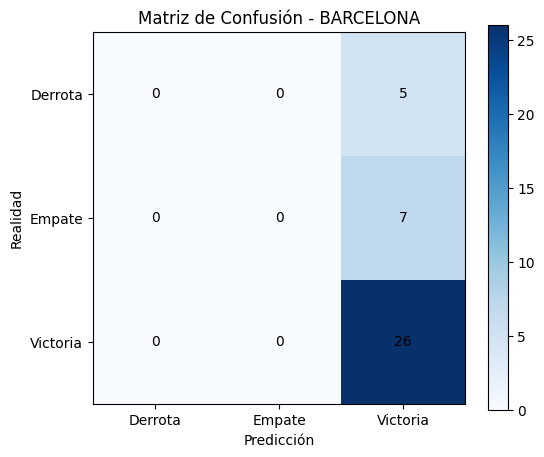

🏃 View run barcelona_xgboost_seq at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/090474646f384734a684cf52b96eef73
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


[I 2025-03-10 17:40:21,071] A new study created in memory with name: no-name-29330771-b4a8-4771-906d-080a0e5f4c2f
[I 2025-03-10 17:40:21,208] Trial 0 finished with value: 0.6578947368421053 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.2853677736504166, 'min_child_weight': 4, 'subsample': 0.8116228933971339, 'colsample_bytree': 0.8735540527030606, 'gamma': 3.559543897578811, 'lambda': 2.224674538316551}. Best is trial 0 with value: 0.6578947368421053.



🔹 Procesando equipo: REAL_MADRID


[I 2025-03-10 17:40:21,300] Trial 1 finished with value: 0.6578947368421053 and parameters: {'n_estimators': 112, 'max_depth': 15, 'learning_rate': 0.2172849410636373, 'min_child_weight': 6, 'subsample': 0.8581236003847961, 'colsample_bytree': 0.8209297949160275, 'gamma': 3.1631342010449686, 'lambda': 1.2497357103591527}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-03-10 17:40:21,475] Trial 2 finished with value: 0.6578947368421053 and parameters: {'n_estimators': 153, 'max_depth': 10, 'learning_rate': 0.26084518448036387, 'min_child_weight': 9, 'subsample': 0.5856126383206535, 'colsample_bytree': 0.6709993923759899, 'gamma': 3.9063743636447, 'lambda': 0.7949902710285855}. Best is trial 0 with value: 0.6578947368421053.
[I 2025-03-10 17:40:21,734] Trial 3 finished with value: 0.6710526315789473 and parameters: {'n_estimators': 238, 'max_depth': 8, 'learning_rate': 0.12370735790357455, 'min_child_weight': 3, 'subsample': 0.8543339893695385, 'colsample_bytree': 0.746378442457

Mejores parámetros para REAL_MADRID: {'n_estimators': 252, 'max_depth': 11, 'learning_rate': 0.18137191067215452, 'min_child_weight': 10, 'subsample': 0.9407949607625083, 'colsample_bytree': 0.8312321830014857, 'gamma': 4.941476708088022, 'reg_lambda': 1.923250947709234}

📊 Resultados para REAL_MADRID: Accuracy=0.7632, Precision=0.5824, Recall=0.7632, F1-score=0.6606

Reporte de clasificación:
               precision    recall  f1-score   support

 Derrota (0)       0.00      0.00      0.00         1
  Empate (1)       0.00      0.00      0.00         8
Victoria (2)       0.76      1.00      0.87        29

    accuracy                           0.76        38
   macro avg       0.25      0.33      0.29        38
weighted avg       0.58      0.76      0.66        38



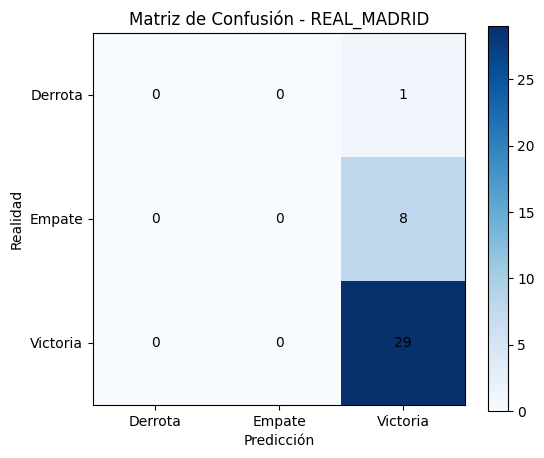

🏃 View run real_madrid_xgboost_seq at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/dc0a842608d347e7b376dad8ac71d351
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
# Bucle para procesar cada equipo
for equipo in equipos:
    print(f"\n🔹 Procesando equipo: {equipo.upper()}")

    # Cargar datos
    file_path = file_path_template.format(equipo)
    df = pd.read_csv(file_path)

    # Preprocesamiento de datos
    df = df.drop(columns=["season", "date", "team"])
    label_encoder = LabelEncoder()
    df["rival_team"] = label_encoder.fit_transform(df["rival_team"])

    # Reasignar etiquetas para XGBoost (de -1, 0, 1 a 0, 1, 2)
    df["result"] = df["result"].replace({-1: 0, 0: 1, 1: 2})

    # Definir variables predictoras y objetivo
    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y = df["result"]

    # Número de partidos a usar en validación secuencial
    n_validacion = 38  

    # Escalar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Aplicar PCA
    pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
    X_pca = pca.fit_transform(X_scaled)

    # Dividir en entrenamiento y validación
    X_train_pca = X_pca[:-n_validacion]  
    y_train = y.iloc[:-n_validacion].copy()
    X_val_pca = X_pca[-n_validacion:]  
    y_val = y.iloc[-n_validacion:].copy()

    # Función de optimización con Optuna
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "lambda": trial.suggest_float("lambda", 0, 5)
        }

        # División interna para optimización
        X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
            X_train_pca, y_train, test_size=0.2, random_state=42, stratify=y_train)

        # Entrenar modelo
        model = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
        model.fit(X_train_opt, y_train_opt)

        # Evaluar modelo
        y_pred_opt = model.predict(X_val_opt)
        return accuracy_score(y_val_opt, y_pred_opt)

    # Ejecutar Optuna con 50 trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    # Obtener los mejores parámetros
    best_params = study.best_params
    best_params["reg_lambda"] = best_params.pop("lambda")  # Ajuste de nombre

    print(f"Mejores parámetros para {equipo.upper()}:", best_params)

    # Inicializar listas de resultados
    y_pred_seq = []
    y_real_seq = []

    with mlflow.start_run(run_name=f"{equipo}_xgboost_seq"):
        mlflow.set_tag("team", equipo)
        mlflow.log_param("model_type", "XGBoost + PCA + Optuna")
        mlflow.log_param("approach", "Sequential Validation")
        mlflow.log_param("test_size", n_validacion)

        # Registrar hiperparámetros
        for param, value in best_params.items():
            mlflow.log_param(param, value)

        mlflow.log_param("pca_components", pca.n_components_)

        # Validación secuencial acumulativa
        for i in range(n_validacion):
            # Datos hasta el partido actual
            X_train_seq = X_pca[: -(n_validacion - i)]
            y_train_seq = y.iloc[: -(n_validacion - i)]

            X_test_seq = X_pca[-(n_validacion - i)].reshape(1, -1)
            y_test_seq = y.iloc[-(n_validacion - i)]

            # Entrenar modelo con los datos disponibles hasta ahora
            model_xgb = xgb.XGBClassifier(**best_params, random_state=42, enable_categorical=False, use_label_encoder=False, eval_metric="mlogloss")
            model_xgb.fit(X_train_seq, np.array(y_train_seq), verbose=False)

            # Predecir el siguiente partido
            y_pred_next = model_xgb.predict(X_test_seq)[0]

            # Guardar predicción y resultado real
            y_pred_seq.append(y_pred_next)
            y_real_seq.append(y_test_seq)

        # Evaluación final
        accuracy = accuracy_score(y_real_seq, y_pred_seq)
        precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

        # Registrar métricas en MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        print(f"\nResultados para {equipo.upper()}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

        # Reporte de clasificación
        report = classification_report(y_real_seq, y_pred_seq, labels=[0, 1, 2], target_names=["Derrota (0)", "Empate (1)", "Victoria (2)"])
        print("\nReporte de clasificación:\n", report)

        # Matriz de confusión
        conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[0, 1, 2])

        plt.figure(figsize=(6, 5))
        plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
        plt.colorbar()
        plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión - {equipo.upper()}")

        for i in range(3):
            for j in range(3):
                plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

        plt.show()

#### Todos los equipos con SMOTE para intentar aumentar el f1_score

- Itera sobre varios equipos y entrena un modelo por cada uno  
- Aplica preprocesamiento con escalado y PCA  
- Optimiza hiperparámetros con Optuna usando un único split de validación  
- Balancea clases con SMOTE en cada entrenamiento  
- Realiza validación secuencial simulando la predicción partido a partido  
- Registra la distribución de clases antes de SMOTE en cada iteración  
- Evalúa rendimiento con métricas estándar de clasificación


[I 2025-03-30 12:36:13,889] A new study created in memory with name: no-name-13822243-3049-4a41-b172-54cc2156a0b4
[I 2025-03-30 12:36:13,977] Trial 0 finished with value: 0.45394736842105265 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.2539989795247339, 'min_child_weight': 2, 'subsample': 0.9497511120168857, 'colsample_bytree': 0.7186067192862668, 'gamma': 3.672673749267859, 'lambda': 1.1405919644926688}. Best is trial 0 with value: 0.45394736842105265.



Procesando equipo: VALENCIA


[I 2025-03-30 12:36:14,174] Trial 1 finished with value: 0.40131578947368424 and parameters: {'n_estimators': 160, 'max_depth': 15, 'learning_rate': 0.02696198474861048, 'min_child_weight': 5, 'subsample': 0.5524965914597679, 'colsample_bytree': 0.9173098197769922, 'gamma': 4.790264659731293, 'lambda': 3.43516560643706}. Best is trial 0 with value: 0.45394736842105265.
[I 2025-03-30 12:36:14,659] Trial 2 finished with value: 0.3881578947368421 and parameters: {'n_estimators': 248, 'max_depth': 6, 'learning_rate': 0.15597400347070248, 'min_child_weight': 8, 'subsample': 0.589988647934635, 'colsample_bytree': 0.8754678429011246, 'gamma': 1.4531520704080658, 'lambda': 0.7229133033267909}. Best is trial 0 with value: 0.45394736842105265.
[I 2025-03-30 12:36:15,269] Trial 3 finished with value: 0.40789473684210525 and parameters: {'n_estimators': 74, 'max_depth': 5, 'learning_rate': 0.10298595598966111, 'min_child_weight': 8, 'subsample': 0.6841939093081055, 'colsample_bytree': 0.9514040457

Mejores parámetros para VALENCIA: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.2539989795247339, 'min_child_weight': 2, 'subsample': 0.9497511120168857, 'colsample_bytree': 0.7186067192862668, 'gamma': 3.672673749267859, 'reg_lambda': 1.1405919644926688}
Distribución de clases antes de SMOTE (iteración 1): {1: 200, 2: 329, 0: 231}
Distribución de clases antes de SMOTE (iteración 2): {1: 200, 2: 330, 0: 231}
Distribución de clases antes de SMOTE (iteración 3): {1: 200, 2: 331, 0: 231}
Distribución de clases antes de SMOTE (iteración 4): {1: 200, 2: 331, 0: 232}
Distribución de clases antes de SMOTE (iteración 5): {1: 200, 2: 331, 0: 233}
Distribución de clases antes de SMOTE (iteración 6): {1: 200, 2: 332, 0: 233}
Distribución de clases antes de SMOTE (iteración 7): {1: 201, 2: 332, 0: 233}
Distribución de clases antes de SMOTE (iteración 8): {1: 201, 2: 332, 0: 234}
Distribución de clases antes de SMOTE (iteración 9): {1: 201, 2: 332, 0: 235}
Distribución de clases antes de 

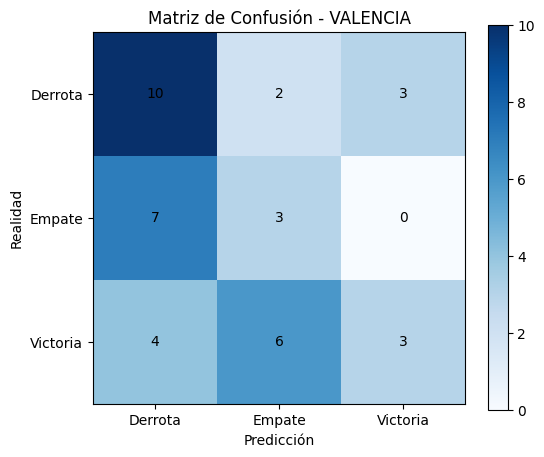

🏃 View run valencia_xgboost_seq_smote_nocv at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/ece0e23a60f945239c47287f0a1bedc9
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


[I 2025-03-30 12:37:17,133] A new study created in memory with name: no-name-a28de44e-d4e2-42f7-ba64-15cfd3dfb236



Procesando equipo: BARCELONA


[I 2025-03-30 12:37:18,403] Trial 0 finished with value: 0.5460526315789473 and parameters: {'n_estimators': 289, 'max_depth': 8, 'learning_rate': 0.21490791921378405, 'min_child_weight': 3, 'subsample': 0.5843008124546809, 'colsample_bytree': 0.5386717602862824, 'gamma': 0.6309607301337672, 'lambda': 0.4900467942812686}. Best is trial 0 with value: 0.5460526315789473.
[I 2025-03-30 12:37:18,701] Trial 1 finished with value: 0.506578947368421 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.26502425852092276, 'min_child_weight': 6, 'subsample': 0.6959994443085105, 'colsample_bytree': 0.6628013435607282, 'gamma': 3.3811119691030322, 'lambda': 2.9873227202731845}. Best is trial 0 with value: 0.5460526315789473.
[I 2025-03-30 12:37:19,385] Trial 2 finished with value: 0.4934210526315789 and parameters: {'n_estimators': 157, 'max_depth': 14, 'learning_rate': 0.08455506896709501, 'min_child_weight': 10, 'subsample': 0.8128619372334875, 'colsample_bytree': 0.74481273

Mejores parámetros para BARCELONA: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.2946290348719582, 'min_child_weight': 4, 'subsample': 0.5688658702826841, 'colsample_bytree': 0.6827569786771934, 'gamma': 0.3422919829216087, 'reg_lambda': 1.144994508131745}
Distribución de clases antes de SMOTE (iteración 1): {2: 526, 1: 140, 0: 94}
Distribución de clases antes de SMOTE (iteración 2): {2: 526, 1: 141, 0: 94}
Distribución de clases antes de SMOTE (iteración 3): {2: 527, 1: 141, 0: 94}
Distribución de clases antes de SMOTE (iteración 4): {2: 528, 1: 141, 0: 94}
Distribución de clases antes de SMOTE (iteración 5): {2: 529, 1: 141, 0: 94}
Distribución de clases antes de SMOTE (iteración 6): {2: 530, 1: 141, 0: 94}
Distribución de clases antes de SMOTE (iteración 7): {2: 531, 1: 141, 0: 94}
Distribución de clases antes de SMOTE (iteración 8): {2: 531, 1: 142, 0: 94}
Distribución de clases antes de SMOTE (iteración 9): {2: 532, 1: 142, 0: 94}
Distribución de clases antes de SMOTE (

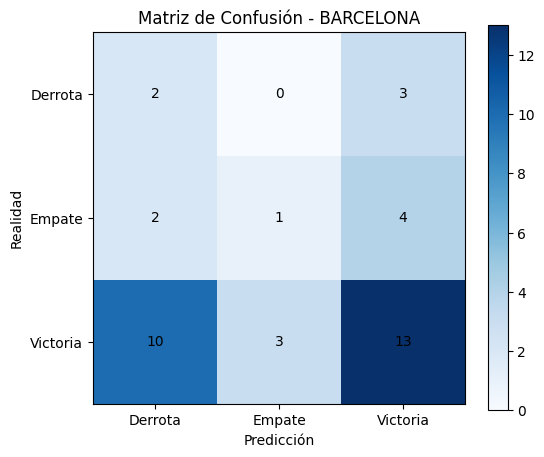

🏃 View run barcelona_xgboost_seq_smote_nocv at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/915cdbea05d64e7da97acb6dee2a87cc
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


[I 2025-03-30 12:39:13,258] A new study created in memory with name: no-name-b6082bb9-6543-4efc-97f6-78afdb4d3834



Procesando equipo: REAL_MADRID


[I 2025-03-30 12:39:14,377] Trial 0 finished with value: 0.5526315789473685 and parameters: {'n_estimators': 272, 'max_depth': 6, 'learning_rate': 0.11942905732443253, 'min_child_weight': 5, 'subsample': 0.6746368225717325, 'colsample_bytree': 0.9866326150546814, 'gamma': 1.2846553182545772, 'lambda': 4.059808571615625}. Best is trial 0 with value: 0.5526315789473685.
[I 2025-03-30 12:39:14,850] Trial 1 finished with value: 0.5131578947368421 and parameters: {'n_estimators': 71, 'max_depth': 13, 'learning_rate': 0.19780701661385508, 'min_child_weight': 5, 'subsample': 0.5444820419536704, 'colsample_bytree': 0.6724872235506519, 'gamma': 3.471363164729783, 'lambda': 0.6249409384886889}. Best is trial 0 with value: 0.5526315789473685.
[I 2025-03-30 12:39:15,808] Trial 2 finished with value: 0.5526315789473685 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.18491606782586725, 'min_child_weight': 5, 'subsample': 0.8624213479873799, 'colsample_bytree': 0.658853627344

Mejores parámetros para REAL_MADRID: {'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.09367793367389009, 'min_child_weight': 3, 'subsample': 0.9296553573838104, 'colsample_bytree': 0.9108313718653399, 'gamma': 0.05838634867146841, 'reg_lambda': 1.7164600996584385}
Distribución de clases antes de SMOTE (iteración 1): {2: 517, 1: 122, 0: 121}
Distribución de clases antes de SMOTE (iteración 2): {2: 518, 1: 122, 0: 121}
Distribución de clases antes de SMOTE (iteración 3): {2: 519, 1: 122, 0: 121}
Distribución de clases antes de SMOTE (iteración 4): {2: 520, 1: 122, 0: 121}
Distribución de clases antes de SMOTE (iteración 5): {2: 521, 1: 122, 0: 121}
Distribución de clases antes de SMOTE (iteración 6): {2: 522, 1: 122, 0: 121}
Distribución de clases antes de SMOTE (iteración 7): {2: 522, 1: 122, 0: 122}
Distribución de clases antes de SMOTE (iteración 8): {2: 523, 1: 122, 0: 122}
Distribución de clases antes de SMOTE (iteración 9): {2: 524, 1: 122, 0: 122}
Distribución de clases an

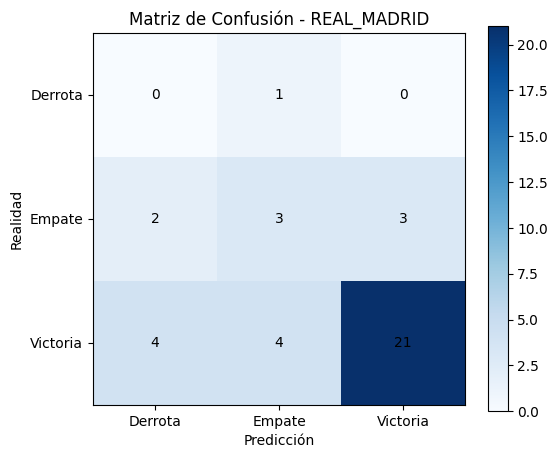

🏃 View run real_madrid_xgboost_seq_smote_nocv at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/a2daf5773299484ab6818fd1c5e527b0
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import optuna
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import warnings
warnings.filterwarnings("ignore")

equipos = ["valencia", "barcelona", "real_madrid", "ath_bilbao"]
file_path_template = "../../datasets/datasets_equipos/{}.csv"

for equipo in equipos:
    print(f"\nProcesando equipo: {equipo.upper()}")

    file_path = file_path_template.format(equipo)
    df = pd.read_csv(file_path)

    df = df.drop(columns=["season", "date", "team"])
    label_encoder = LabelEncoder()
    df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
    df["result"] = df["result"].replace({-1: 0, 0: 1, 1: 2})

    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y = df["result"]
    n_validacion = 38

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    X_train_pca = X_pca[:-n_validacion]
    y_train = y.iloc[:-n_validacion].copy()

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "lambda": trial.suggest_float("lambda", 0, 5)
        }

        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_pca, y_train, test_size=0.2, random_state=42, stratify=y_train)

        smote = SMOTE(random_state=42)
        X_train_bal, y_train_bal = smote.fit_resample(X_train_split, y_train_split)

        model = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric="mlogloss", )
        model.fit(X_train_bal, y_train_bal)

        y_pred = model.predict(X_val_split)
        return accuracy_score(y_val_split, y_pred)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    best_params["reg_lambda"] = best_params.pop("lambda")

    print(f"Mejores parámetros para {equipo.upper()}:", best_params)

    y_pred_seq = []
    y_real_seq = []
    distribuciones = {}

    with mlflow.start_run(run_name=f"{equipo}_xgboost_seq_smote_pca"):
        mlflow.set_tag("team", equipo)
        mlflow.log_param("aproach", "XGBoost + PCA + Optuna + SMOTE")
        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("test_size", n_validacion)

        for param, value in best_params.items():
            mlflow.log_param(param, value)

        mlflow.log_param("pca_components", pca.n_components_)

        for i in range(n_validacion):
            X_train_seq = X_pca[: -(n_validacion - i)]
            y_train_seq = y.iloc[: -(n_validacion - i)]

            dist = dict(Counter(y_train_seq))
            distribuciones[f"iter_{i+1}"] = dist

            smote = SMOTE(random_state=42)
            X_train_seq_bal, y_train_seq_bal = smote.fit_resample(X_train_seq, y_train_seq)

            X_test_seq = X_pca[-(n_validacion - i)].reshape(1, -1)
            y_test_seq = y.iloc[-(n_validacion - i)]

            model_xgb = xgb.XGBClassifier(**best_params, random_state=42, enable_categorical=False, use_label_encoder=False, eval_metric="mlogloss")
            model_xgb.fit(X_train_seq_bal, np.array(y_train_seq_bal), verbose=False)

            y_pred_next = model_xgb.predict(X_test_seq)[0]
            y_pred_seq.append(y_pred_next)
            y_real_seq.append(y_test_seq)

        filename = f"{equipo}_class_distribution.json"
        with open(filename, "w") as f:
            json.dump(distribuciones, f, indent=2)
        mlflow.log_artifact(filename)
        
        accuracy = accuracy_score(y_real_seq, y_pred_seq)
        precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        print(f"\nResultados para {equipo.upper()}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

        report = classification_report(y_real_seq, y_pred_seq, labels=[0, 1, 2], target_names=["Derrota (0)", "Empate (1)", "Victoria (2)"])
        print("\nReporte de clasificación:\n", report)

        conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[0, 1, 2])

        plt.figure(figsize=(6, 5))
        plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
        plt.colorbar()
        plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión - {equipo.upper()}")

        for i in range(3):
            for j in range(3):
                plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

        plt.show()
